In [2]:
# Imports
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score
import ir_datasets
from collections import defaultdict
import warnings
warnings.filterwarnings('ignore')

# Add project root to path
project_root = os.path.dirname(os.path.abspath('.'))
if project_root not in sys.path:
    sys.path.append(project_root)

# Import our services
from services.vectorization.embedding_vectorizer import load_embedding_model
from services.matcher import Matcher
from services.query_processor import QueryProcessor

# Set up plotting style
plt.style.use('default')

print("✓ All imports completed successfully!")
print(f"✓ Project root: {project_root}")

INFO:services.indexing_service:Loading required NLTK resources...


✓ All imports completed successfully!
✓ Project root: c:\Users\Ahmad\Desktop\ir_system_project


In [3]:
# Load documents from database and queries/qrels from evaluation folder
import sqlite3
import pandas as pd
from collections import defaultdict
import os

dataset_name = "antique/test"
print(f"Loading data for: {dataset_name}")

# 1. Load documents from database
print("Loading documents from database...")
db_path = os.path.join(project_root, "data", "ir_documents.db")
print(f"Database path: {db_path}")

conn = sqlite3.connect(db_path)
cursor = conn.cursor()
cursor.execute("SELECT doc_id, text FROM documents WHERE dataset = ?", (dataset_name,))
rows = cursor.fetchall()
conn.close()

documents = {row[0]: row[1] for row in rows}
print(f"Loaded {len(documents)} documents from database")

# 2. Load queries from evaluation folder
print("Loading queries from evaluation folder...")
queries_path = os.path.join(project_root, "evaluation", "antique_test.queries.tsv")
queries_df = pd.read_csv(queries_path, sep='\t', header=None, names=['query_id', 'query_text'])
queries = dict(zip(queries_df['query_id'], queries_df['query_text']))

# 3. Load qrels from evaluation folder
print("Loading qrels from evaluation folder...")
qrels_path = os.path.join(project_root, "evaluation", "antique_test.qrels")
qrels_df = pd.read_csv(qrels_path, sep=' ', header=None, names=['query_id', 'run_id', 'doc_id', 'relevance'])

# Group by query_id, handle NaN values
qrels = {}
for _, row in qrels_df.iterrows():
    query_id = str(row['query_id'])
    doc_id = str(row['doc_id'])
    
    # Handle NaN values in relevance
    if pd.isna(row['relevance']):
        relevance = 0
    else:
        relevance = int(row['relevance'])
    
    if query_id not in qrels:
        qrels[query_id] = {}
    qrels[query_id][doc_id] = relevance

print(f"✓ Loaded: {len(documents)} documents, {len(queries)} queries, {len(qrels)} query-relevance sets")
print(f"Sample query: {list(queries.items())[0]}")
print(f"Sample qrel: {list(qrels.items())[0]}")

Loading data for: antique/test
Loading documents from database...
Database path: c:\Users\Ahmad\Desktop\ir_system_project\data\ir_documents.db
Loaded 403666 documents from database
Loading queries from evaluation folder...
Loading qrels from evaluation folder...
✓ Loaded: 403666 documents, 200 queries, 200 query-relevance sets
Sample query: (3990512, 'how can we get concentration onsomething?')
Sample qrel: ('1964316', {'1964316_5': 4, '1674088_11': 1, '1218838_13': 2, '1519022_15': 2, '3059341_5': 2, '4126855_1': 2, '2434719_9': 2, '3786452_1': 2, '1964316_3': 4, '1964316_2': 4, '767911_0': 2, '1964316_0': 4, '1964316_1': 3, '1964316_4': 3, '1248144_1': 2, '2768257_0': 2, '1519022_3': 2, '2245059_0': 2, '1013722_5': 2, '650233_14': 2, '2305171_0': 2, '3435824_3': 2, '636973_2': 1, '1724160_7': 2, '3592532_6': 2, '636973_1': 1, '1148987_10': 2, '2787567_1': 2, '647686_0': 2, '369616_4': 4, '1759521_19': 3, '2929011_0': 4, '1810312_4': 2})


In [4]:
# Load existing Embedding model
import joblib
import os

dataset_name = "antique/test"
print(f"Loading Embedding model for: {dataset_name}")

# Use absolute paths
model_path = os.path.join(project_root, "models", "antique_test_embedding_model.joblib")
vectors_path = os.path.join(project_root, "vectors", "antique_test_embedding_vectors.joblib")

print(f"Model path: {model_path}")
print(f"Vectors path: {vectors_path}")

if os.path.exists(model_path) and os.path.exists(vectors_path):
    print("Loading model...")
    embedding_model = joblib.load(model_path)
    data = joblib.load(vectors_path)
    embedding_vectors = data["vectors"]
    doc_ids = data["doc_ids"]
    
    print(f"✓ Embedding model loaded successfully!")
    print(f"- Vectors shape: {embedding_vectors.shape}")
    print(f"- Number of documents: {len(doc_ids)}")
    print(f"- Embedding dimension: {embedding_vectors.shape[1]}")
    print(f"- Model saved in: models/antique_test_embedding_model.joblib")
    print(f"- Vectors saved in: vectors/antique_test_embedding_vectors.joblib")
else:
    print("❌ Model files not found!")
    print(f"Model exists: {os.path.exists(model_path)}")
    print(f"Vectors exists: {os.path.exists(vectors_path)}")

Loading Embedding model for: antique/test
Model path: c:\Users\Ahmad\Desktop\ir_system_project\models\antique_test_embedding_model.joblib
Vectors path: c:\Users\Ahmad\Desktop\ir_system_project\vectors\antique_test_embedding_vectors.joblib
Loading model...
✓ Embedding model loaded successfully!
- Vectors shape: (403666, 384)
- Number of documents: 403666
- Embedding dimension: 384
- Model saved in: models/antique_test_embedding_model.joblib
- Vectors saved in: vectors/antique_test_embedding_vectors.joblib


In [5]:
# Create Matcher and Query Processor for Embedding evaluation
from services.matcher import Matcher

print("Creating Embedding Matcher...")

# Create Matcher for Embedding (this will create its own QueryProcessor)
matcher = Matcher(
    doc_vectors=embedding_vectors,
    embedding_model=embedding_model,  # Pass the loaded embedding model
    method="embedding",
    dataset_name="antique/test"
)

# Manually set the loaded embedding model to the matcher's query processor
matcher.query_processor.embedding_model = embedding_model

print(f"✓ Matcher created with method: {matcher.method}")
print(f"✓ Embedding model loaded in Matcher's QueryProcessor: {matcher.query_processor.embedding_model is not None}")
print(f"✓ Document vectors shape: {matcher.doc_vectors.shape}")
print(f"✓ Number of queries to evaluate: {len(queries)}")

# Test with a sample query
sample_query_id = list(queries.keys())[0]
sample_query_text = queries[sample_query_id]
print(f"\nSample query test:")
print(f"Query ID: {sample_query_id}")
print(f"Query text: {sample_query_text}")

# Step 1: Process query using Matcher's QueryProcessor
processed_query = matcher.query_processor.process_query(sample_query_text)
print(f"Processed query: {processed_query}")

# Step 2: Get query vector for matching
query_vector = matcher.query_processor.get_query_vector_for_matching(sample_query_text)
print(f"Query vector shape: {query_vector.shape}")

# Step 3: Get matching results using Matcher
results = matcher.match(sample_query_text, top_k=10)
print(f"Top 10 results: {len(results)} matches found")

# Show first few results
for i, (doc_idx, score) in enumerate(results[:5]):
    doc_id = doc_ids[doc_idx] if doc_idx < len(doc_ids) else f"doc_{doc_idx}"
    print(f"  {i+1}. Doc {doc_idx}: score {score:.4f}")

Creating Embedding Matcher...
✓ Matcher created with method: embedding
✓ Embedding model loaded in Matcher's QueryProcessor: True
✓ Document vectors shape: (403666, 384)
✓ Number of queries to evaluate: 200

Sample query test:
Query ID: 3990512
Query text: how can we get concentration onsomething?
Processed query: how can we get concentration onsomething?


Batches: 100%|██████████| 1/1 [00:00<00:00,  1.57it/s]


Query vector shape: (1, 384)


Batches: 100%|██████████| 1/1 [00:00<00:00, 22.31it/s]


Top 10 results: 10 matches found
  1. Doc 256467: score 0.6333
  2. Doc 288355: score 0.6331
  3. Doc 288350: score 0.5807
  4. Doc 301175: score 0.5639
  5. Doc 181118: score 0.5612


In [6]:
# Run evaluation on all queries
print("Starting Embedding evaluation on all queries...")

# Initialize results storage
evaluation_results = {}
total_queries = len(queries)
print(f"Evaluating {total_queries} queries...")

# Process each query
for i, (query_id, query_text) in enumerate(queries.items()):
    if i % 20 == 0:  # Progress indicator every 20 queries
        print(f"Processing query {i+1}/{total_queries}: {query_id}")
    
    try:
        # Get matching results for this query (top 10 for evaluation)
        results = matcher.match(query_text, top_k=10)  # Get top 10 results only
        
        # Store results
        evaluation_results[query_id] = {
            'query_text': query_text,
            'results': results,  # List of (doc_idx, score) tuples
            'num_results': len(results)
        }
        
    except Exception as e:
        print(f"Error processing query {query_id}: {e}")
        evaluation_results[query_id] = {
            'query_text': query_text,
            'results': [],
            'num_results': 0,
            'error': str(e)
        }

print(f"✓ Evaluation completed!")
print(f"- Processed queries: {len(evaluation_results)}")
print(f"- Successful queries: {sum(1 for r in evaluation_results.values() if 'error' not in r)}")
print(f"- Failed queries: {sum(1 for r in evaluation_results.values() if 'error' in r)}")

# Show sample results
sample_query_id = list(evaluation_results.keys())[0]
sample_results = evaluation_results[sample_query_id]
print(f"\nSample results for query {sample_query_id}:")
print(f"- Query: {sample_results['query_text']}")
print(f"- Results count: {sample_results['num_results']}")
print(f"- Top 5 results: {sample_results['results'][:5]}")

Starting Embedding evaluation on all queries...
Evaluating 200 queries...
Processing query 1/200: 3990512


Batches: 100%|██████████| 1/1 [00:01<00:00,  1.78s/it]


Processing query 21/200: 3698636


Batches: 100%|██████████| 1/1 [00:00<00:00, 25.75it/s]


Processing query 41/200: 3499881


Batches: 100%|██████████| 1/1 [00:00<00:00, 62.15it/s]


Processing query 61/200: 4377861


Batches: 100%|██████████| 1/1 [00:00<00:00, 39.77it/s]


Processing query 81/200: 2529114


Batches: 100%|██████████| 1/1 [00:00<00:00, 45.80it/s]


Processing query 101/200: 654124


Batches: 100%|██████████| 1/1 [00:00<00:00, 45.57it/s]


Processing query 121/200: 1477322


Batches: 100%|██████████| 1/1 [00:00<00:00, 10.57it/s]


Processing query 141/200: 159716


Batches: 100%|██████████| 1/1 [00:00<00:00, 27.10it/s]


Processing query 161/200: 172731


Batches: 100%|██████████| 1/1 [00:00<00:00, 52.36it/s]


Processing query 181/200: 949154


Batches: 100%|██████████| 1/1 [00:00<00:00,  5.13it/s]


✓ Evaluation completed!
- Processed queries: 200
- Successful queries: 200
- Failed queries: 0

Sample results for query 3990512:
- Query: how can we get concentration onsomething?
- Results count: 10
- Top 5 results: [(256467, 0.6332624), (288355, 0.6331345), (288350, 0.5807296), (301175, 0.5638922), (181118, 0.56121826)]


In [7]:
# Calculate evaluation metrics (Precision@10, Recall@10, MRR, MAP)
print("Calculating evaluation metrics...")

# Initialize metrics storage
metrics = {
    'precision_at_10': [],
    'recall_at_10': [],
    'mrr': [],
    'map': []
}

# Process each query
for query_id, query_data in evaluation_results.items():
    if 'error' in query_data:
        continue  # Skip failed queries
    
    query_text = query_data['query_text']
    results = query_data['results']  # List of (doc_idx, score) tuples
    
    # Get relevant documents for this query
    relevant_docs = qrels.get(str(query_id), {})
    print(f"Query {query_id}: {len(relevant_docs)} relevant docs")
    
    if not relevant_docs:
        continue  # Skip queries with no relevant documents
    
    # Convert results to document IDs
    retrieved_doc_ids = []
    for doc_idx, score in results:
        if doc_idx < len(doc_ids):
            retrieved_doc_ids.append(doc_ids[doc_idx])
        else:
            retrieved_doc_ids.append(f"doc_{doc_idx}")
    
    # Calculate Precision@10
    top_10_docs = retrieved_doc_ids[:10]
    relevant_in_top_10 = sum(1 for doc_id in top_10_docs if doc_id in relevant_docs)
    precision_at_10 = relevant_in_top_10 / 10 if top_10_docs else 0
    metrics['precision_at_10'].append(precision_at_10)
    
    # Calculate Recall@10
    total_relevant = len(relevant_docs)
    recall_at_10 = relevant_in_top_10 / total_relevant if total_relevant > 0 else 0
    metrics['recall_at_10'].append(recall_at_10)
    
    # Calculate MRR (Mean Reciprocal Rank)
    mrr = 0
    for rank, doc_id in enumerate(retrieved_doc_ids, 1):
        if doc_id in relevant_docs:
            mrr = 1.0 / rank
            break
    metrics['mrr'].append(mrr)
    
    # Calculate MAP (Mean Average Precision)
    ap = 0
    relevant_found = 0
    for rank, doc_id in enumerate(retrieved_doc_ids, 1):
        if doc_id in relevant_docs:
            relevant_found += 1
            ap += relevant_found / rank
    ap = ap / total_relevant if total_relevant > 0 else 0
    metrics['map'].append(ap)

# Calculate average metrics
if metrics['precision_at_10']:
    avg_metrics = {
        'avg_precision_at_10': np.mean(metrics['precision_at_10']),
        'avg_recall_at_10': np.mean(metrics['recall_at_10']),
        'avg_mrr': np.mean(metrics['mrr']),
        'avg_map': np.mean(metrics['map'])
    }
    
    print(f"✓ Metrics calculated!")
    print(f"- Queries with metrics: {len(metrics['precision_at_10'])}")
    print(f"- Average Precision@10: {avg_metrics['avg_precision_at_10']:.4f}")
    print(f"- Average Recall@10: {avg_metrics['avg_recall_at_10']:.4f}")
    print(f"- Average MRR: {avg_metrics['avg_mrr']:.4f}")
    print(f"- Average MAP: {avg_metrics['avg_map']:.4f}")
else:
    print("❌ No metrics calculated - check qrels data")

Calculating evaluation metrics...
Query 3990512: 36 relevant docs
Query 714612: 30 relevant docs
Query 2528767: 23 relevant docs
Query 821387: 41 relevant docs
Query 1880028: 31 relevant docs
Query 4448097: 36 relevant docs
Query 1287437: 33 relevant docs
Query 2956570: 29 relevant docs
Query 1351675: 31 relevant docs
Query 1783010: 18 relevant docs
Query 2799913: 37 relevant docs
Query 2142044: 23 relevant docs
Query 707303: 25 relevant docs
Query 676028: 31 relevant docs
Query 2484180: 36 relevant docs
Query 2307305: 31 relevant docs
Query 2814599: 23 relevant docs
Query 3369088: 44 relevant docs
Query 1702151: 34 relevant docs
Query 851124: 30 relevant docs
Query 3698636: 40 relevant docs
Query 1844896: 30 relevant docs
Query 2290758: 37 relevant docs
Query 143833: 26 relevant docs
Query 3910925: 40 relevant docs
Query 2643507: 34 relevant docs
Query 1502604: 34 relevant docs
Query 4283542: 29 relevant docs
Query 3554263: 34 relevant docs
Query 3313308: 40 relevant docs
Query 435746

Creating visualizations and saving results...


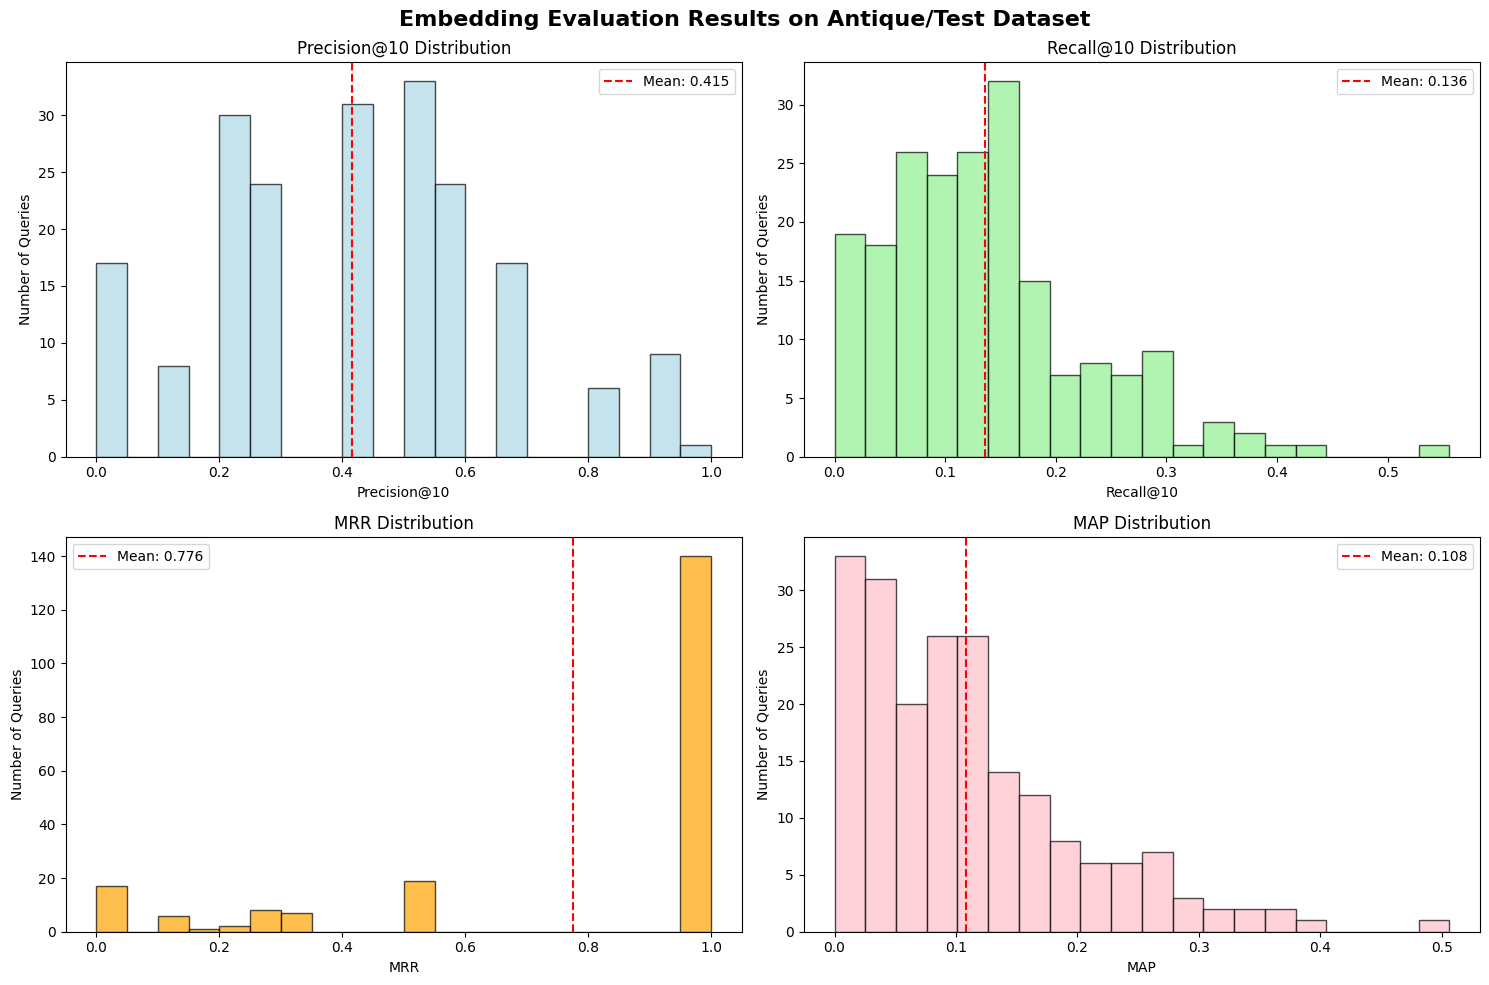

✓ Results saved to: c:\Users\Ahmad\Desktop\ir_system_project\evaluation\embedding_antique_results.json

📊 Embedding Evaluation Summary:
Dataset: antique/test
Method: Embedding (SentenceTransformer)
Total Queries: 200
Queries with Metrics: 200
Average Precision@10: 0.4155
Average Recall@10: 0.1364
Average MRR: 0.7757
Average MAP: 0.1083


In [8]:
# Plot results and save metrics
import matplotlib.pyplot as plt
import json
from datetime import datetime

print("Creating visualizations and saving results...")

# Create figure with subplots
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Embedding Evaluation Results on Antique/Test Dataset', fontsize=16, fontweight='bold')

# 1. Precision@10 distribution
ax1.hist(metrics['precision_at_10'], bins=20, alpha=0.7, color='lightblue', edgecolor='black')
ax1.set_title('Precision@10 Distribution')
ax1.set_xlabel('Precision@10')
ax1.set_ylabel('Number of Queries')
ax1.axvline(avg_metrics['avg_precision_at_10'], color='red', linestyle='--', 
            label=f'Mean: {avg_metrics["avg_precision_at_10"]:.3f}')
ax1.legend()

# 2. Recall@10 distribution
ax2.hist(metrics['recall_at_10'], bins=20, alpha=0.7, color='lightgreen', edgecolor='black')
ax2.set_title('Recall@10 Distribution')
ax2.set_xlabel('Recall@10')
ax2.set_ylabel('Number of Queries')
ax2.axvline(avg_metrics['avg_recall_at_10'], color='red', linestyle='--', 
            label=f'Mean: {avg_metrics["avg_recall_at_10"]:.3f}')
ax2.legend()

# 3. MRR distribution
ax3.hist(metrics['mrr'], bins=20, alpha=0.7, color='orange', edgecolor='black')
ax3.set_title('MRR Distribution')
ax3.set_xlabel('MRR')
ax3.set_ylabel('Number of Queries')
ax3.axvline(avg_metrics['avg_mrr'], color='red', linestyle='--', 
            label=f'Mean: {avg_metrics["avg_mrr"]:.3f}')
ax3.legend()

# 4. MAP distribution
ax4.hist(metrics['map'], bins=20, alpha=0.7, color='pink', edgecolor='black')
ax4.set_title('MAP Distribution')
ax4.set_xlabel('MAP')
ax4.set_ylabel('Number of Queries')
ax4.axvline(avg_metrics['avg_map'], color='red', linestyle='--', 
            label=f'Mean: {avg_metrics["avg_map"]:.3f}')
ax4.legend()

plt.tight_layout()
plt.show()

# Save results
results_summary = {
    'dataset': 'antique/test',
    'method': 'embedding',
    'evaluation_date': datetime.now().isoformat(),
    'total_queries': len(queries),
    'queries_with_metrics': len(metrics['precision_at_10']),
    'average_metrics': avg_metrics,
    'detailed_metrics': {
        'precision_at_10': metrics['precision_at_10'],
        'recall_at_10': metrics['recall_at_10'],
        'mrr': metrics['mrr'],
        'map': metrics['map']
    }
}

# Save to JSON file
results_file = os.path.join(project_root, "evaluation", "embedding_antique_results.json")
with open(results_file, 'w', encoding='utf-8') as f:
    json.dump(results_summary, f, indent=2, ensure_ascii=False)

print(f"✓ Results saved to: {results_file}")

# Print summary
print(f"\n📊 Embedding Evaluation Summary:")
print(f"Dataset: antique/test")
print(f"Method: Embedding (SentenceTransformer)")
print(f"Total Queries: {len(queries)}")
print(f"Queries with Metrics: {len(metrics['precision_at_10'])}")
print(f"Average Precision@10: {avg_metrics['avg_precision_at_10']:.4f}")
print(f"Average Recall@10: {avg_metrics['avg_recall_at_10']:.4f}")
print(f"Average MRR: {avg_metrics['avg_mrr']:.4f}")
print(f"Average MAP: {avg_metrics['avg_map']:.4f}")